In [1]:
# automatically reload imported modules
%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
import sys
import matplotlib
from matplotlib import pyplot as plt
import pylab as pl

from filters import GrayscaleNormalizer

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

FOLDER_PATH = '/Users/delinwang/Desktop/Concrete Crack Images for Classification.rar Folder/'
FOLDER_PATH = 'C:/Users/Dominic/Desktop/Concrete Crack Images for Classification/'

SUTD_PATH = 'C:/Users/Dominic/Desktop/SUTD Cracks/'

In [40]:
imgs = []
normalize_grayscale = GrayscaleNormalizer()

img = cv2.imread(FOLDER_PATH + 'Positive/00001.jpg', 0).astype(np.float32)
imgs.append(img)

img = cv2.imread(SUTD_PATH + 'Positive/00001.jpg', 0).astype(np.float32)
imgs.append(img)

img = cv2.imread(SUTD_PATH + 'Positive/00101.jpg', 0).astype(np.float32)
imgs.append(img)

In [85]:
from filters import *
import preprocessing.shadow_reduction

filters = {}

grayscale       = GrayscaleNormalizer()
bilateral_canny = BilateralCanny()
kernel = np.ones((5,5),np.uint8)

filters['no filter']       = lambda x : x
filters['canny']           = bilateral_canny.canny_img
filters['bilateral canny'] = bilateral_canny.bilateral_canny_img
filters['canny gradient']  = canny_gradient

filters['otsu']            = otsu
filters['tophat']          = tophat
filters['blackhat']        = blackhat
filters['gradient']        = gradient
filters['gradient2']       = gradient2
filters['gradient3']       = gradient3

filters['guass blur']       = lambda x : cv2.GaussianBlur(x,(5,5),0)
filters['bilateral filter'] = lambda x : cv2.bilateralFilter(x.astype(np.uint8),9,75,75)
filters['blur']             = lambda x : cv2.blur(x,(5,5))
filters['grayscale']        = grayscale
filters['adaptive']         = lambda x : cv2.adaptiveThreshold(x.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2
                                                              )
filters['close5x5']        = lambda x : cv2.morphologyEx(x, cv2.MORPH_CLOSE, kernel)
filters['open5x5']         = lambda x : cv2.morphologyEx(x, cv2.MORPH_OPEN, kernel)
filters['dilate5x5']       = lambda x : cv2.dilate(x, kernel, iterations = 1)
filters['erode5x5']        = lambda x : cv2.erode(x, kernel, iterations = 1)
filters['gradient5x5']     = lambda x : cv2.morphologyEx(x, cv2.MORPH_GRADIENT, kernel)
filters['tophat5x5']       = lambda x : cv2.morphologyEx(x, cv2.MORPH_BLACKHAT, kernel)
filters['blackhat5x5']     = lambda x : cv2.morphologyEx(x, cv2.MORPH_TOPHAT, kernel)

filters['thres_bin127']          = lambda x : cv2.threshold(x,127,255,cv2.THRESH_BINARY)[1]
filters['thres_bininv127']       = lambda x : cv2.threshold(x,127,255,cv2.THRESH_BINARY_INV)[1]
filters['thres_bintrunc127']     = lambda x : cv2.threshold(x,127,255,cv2.THRESH_TRUNC)[1]
filters['thres_bintozero127']    = lambda x : cv2.threshold(x,127,255,cv2.THRESH_TOZERO)[1]
filters['thres_bintozeroinv127'] = lambda x : cv2.threshold(x,127,255,cv2.THRESH_TOZERO_INV)[1]

best_filters = {}

best_filters['best_1']     = lambda x : filters['gradient5x5'](filters['adaptive'](filters['blur'](x)))
best_filters['best_2']     = lambda x : filters['erode5x5'](filters['gradient'](filters['adaptive'](x)))
best_filters['best_3']     = lambda x : np.abs(filters['dilate5x5'](filters['guass blur'](filters['blur'](x))) - 255)
best_filters['best_4']     = lambda x : np.abs(filters['open5x5'](filters['adaptive'](filters['blur'](x))) - 255)
best_filters['best_5']     = lambda x : np.abs(filters['adaptive'](filters['thres_bin127'](filters['grayscale'](x))) - 255)
best_filters['best_6']     = lambda x : np.abs(filters['adaptive'](filters['dilate5x5'](filters['bilateral filter'](x))) - 255)
best_filters['best_7']     = lambda x : np.abs(filters['adaptive'](filters['dilate5x5'](filters['blur'](x))) - 255)
best_filters['best_8']     = lambda x : np.abs(filters['adaptive'](filters['gradient'](filters['blur'](x))) - 255)
best_filters['best_10']    = lambda x : np.abs(filters['bilateral filter'](filters['adaptive'](filters['dilate5x5'](x))) - 255)
best_filters['best_11']    = lambda x : np.abs(filters['bilateral filter'](filters['adaptive'](filters['blur'](x))) - 255)
best_filters['best_12']    = lambda x : np.abs(filters['guass blur'](filters['adaptive'](filters['blur'](x))) - 255) 
best_filters['best_13']    = lambda x : filters['gradient'](filters['thres_bin127'](filters['grayscale'](x)))

# filters2 = {}

# for f1_name, f1_func in filters.items():
#     for f2_name, f2_func in filters.items():
#         def combination_func():
#             a = f1_func
#             b = f2_func
#             return lambda x : a(b(x))

#         filters2["{0}\n{1}".format(f1_name, f2_name)] = combination_func()
            
# filters = filters2
    
filters_m2 = {}

bob = [ (1, 5), (1, 6), (1, 13), (3, 5), (3, 6), (6, 3), (6, 6), (6, 7) ]

for f1_name, f1_func in best_filters.items():
    for f2_name, f2_func in best_filters.items():
        
        if (int(f1_name.replace("best_", "")), int(f2_name.replace("best_", ""))) in bob:
            def combination_func():
                a = f1_func
                b = f2_func
                return lambda x : a(x) * b(x)

            filters_m2["{0}\n{1}".format(f1_name, f2_name)] = combination_func()

# filters3 = {}

# for f1_name, f1_func in filters.items():
#     for f2_name, f2_func in filters.items():
#         for f3_name, f3_func in filters.items():
#             def combination_func():
#                 a = f1_func
#                 b = f2_func
#                 c = f3_func
#                 return lambda x : a(b(c(x)))

#             filters3["{0}\n{1}\n{2}".format(f1_name, f2_name, f3_name)] = combination_func()

# filters = filters3

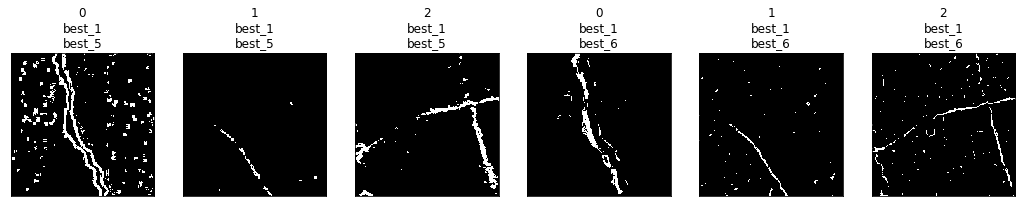

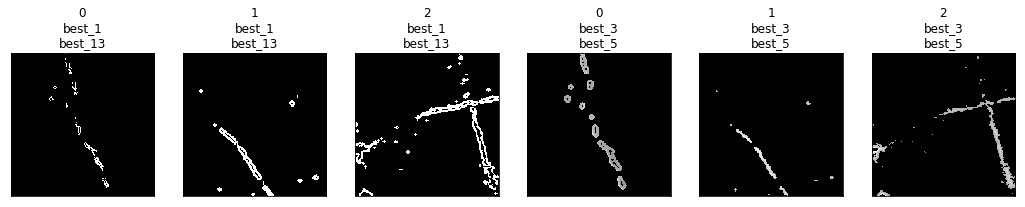

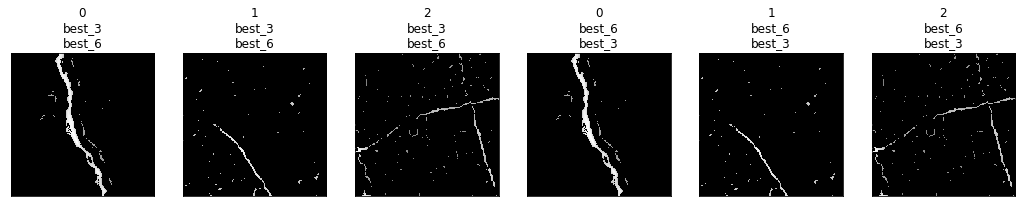

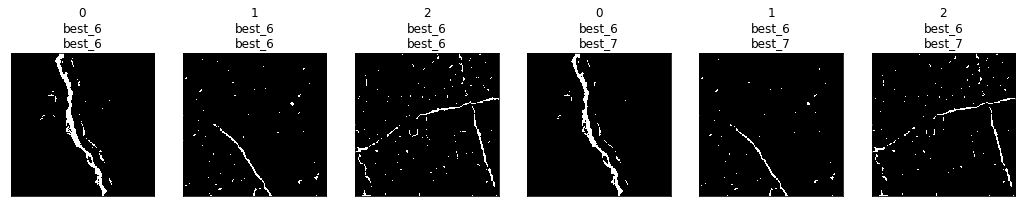

In [86]:
fig_size = (18, 9)

r = len(filters)//6+1
plt.figure(figsize=fig_size)

test_filters = filters_m2

i = 0
for filter_name, filter_func in test_filters.items():
    
    for idx in range(len(imgs)):
        img = filter_func(imgs[idx])
    
        plt.subplot(1, 6, i % 6 + 1), plt.imshow(img, cmap='gray')
        plt.title("{0}\n{1}".format(idx, filter_name)),plt.xticks([]),plt.yticks([])

        i += 1

        if i % 6 == 0:
            plt.show()
            plt.figure(figsize=fig_size)

if i % 6 != 0:
    plt.show()